In [1]:
from scipy.signal import convolve2d
from skimage.feature import canny
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [85]:
from skimage.filters import gaussian, threshold_local
from skimage.transform import hough_line, probabilistic_hough_line
from collections import Counter
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage import draw
from skimage.transform import resize
from skimage.feature import match_template

In [3]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [4]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [91]:
x = [1, 2, 3]
print(x[:-1])
print(x[1:])
print(np.diff(np.array([-1, 4, 7, 9, 10, 13])))
print([x[i] for i in [0, 1]])

[1, 2]
[2, 3]
[5 3 2 1 3]
[1, 2]


In [100]:
def rle_encode(arr):
    if len(arr) == 0:
        return [], [], []

    x = np.copy(arr)
    first_dismatch = np.array(x[1:] != x[:-1])
    distmatch_positions = np.append(np.where(first_dismatch), len(x)-1)
    rle = np.diff(np.append(-1, distmatch_positions))
    values = [x[i] for i in np.cumsum(np.append(0, rle))[:-1]]
    return rle, values
    # where = np.flatnonzero
    # x = np.asarray(x)
    # n = len(x)
    # if n == 0:
    #     return (np.array([], dtype=int),
    #             np.array([], dtype=int),
    #             np.array([], dtype=x.dtype))

    # starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
    # lengths = np.diff(np.r_[starts, n])
    # values = x[starts]

    # if dropna:
    #     mask = ~np.isnan(values)
    #     starts, lengths, values = starts[mask], lengths[mask], values[mask]

    # return starts, lengths, values


In [93]:
def rle_img(img, axis=1):
    if axis == 1:
        rle = [rle_encode(img[:, i])[0] for i in range(img.shape[1])]
        values = [rle_encode(img[:, i])[1] for i in range(img.shape[1])]
        return rle, values
    else:
        rle = [rle_encode(img[i])[0] for i in range(img.shape[0])]
        values = [rle_encode(img[i])[1] for i in range(img.shape[0])]
        return rle, values


In [7]:
def get_consecutive_sum(arr):
    n = len(arr)
    if n == 1:
        return list(arr)
    elif n % 2 == 0:
        return [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
    else:
        result = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        result.append(arr[-2] + arr[-1])
        return result


In [8]:
def get_most_common(rle):
    consecutive_sum = [get_consecutive_sum(column) for column in rle]

    flat_structure = []
    for column_data in consecutive_sum:
        flat_structure += column_data

    most_common = np.argmax(np.bincount(flat_structure))
    return most_common


In [9]:
def get_sum_components(arr, most_common):
    n = len(arr)
    if n == 1:
        return []
    elif n % 2 == 0:
        return [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2) if arr[i] + arr[i + 1] == most_common]
    else:
        result = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2) if arr[i] + arr[i + 1] == most_common]
        if arr[-2] + arr[-1] == most_common:
            result.append((arr[-2], arr[-1]))
        return result


In [10]:
def get_thickness_spacing(rle, m_c=None):
    if m_c is None:
        m_c = get_most_common(rle)

    sum_components = [get_sum_components(column, m_c) for column in rle]
    sum_components = [x for x in sum_components if x]

    flat_sum_structure = []
    for column_data in sum_components:
        flat_sum_structure += column_data

    counter = Counter(flat_sum_structure)
    pair, count = counter.most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing, counter


In [11]:
def rl_decode(starts, lengths, values, minlength=None):
    starts, lengths, values = map(np.asarray, (starts, lengths, values))
    ends = starts + lengths
    n = ends[-1]
    if minlength is not None:
        n = max(minlength, n)
    x = np.full(n, np.nan)
    for lo, hi, val in zip(starts, ends, values):
        x[lo:hi] = val
    return x

def rl_decode_2D(rle, values, output_shape, axis=1):
    starts = [[int(np.sum(arr[:i])) for i in range(len(arr))] for arr in rle]

    decoded = np.zeros(output_shape, dtype=np.int32)
    if axis == 1:
        for i in range(decoded.shape[1]):
            decoded[:, i] = rl_decode(starts[i], rle[i], values[i])
    else:
        for i in range(decoded.shape[0]):
            decoded[i] = rl_decode(starts[i], rle[i], values[i])

    return decoded


In [12]:
def remove_black_blocks(arr, values, max_block_height):
    marked_arr = [[arr[i], 'w' if val == 1 else 'b'] for i, val in enumerate(values)]
    for elem in marked_arr:
        if elem[1] == 'b' and elem[0] < max_block_height:
            elem[1] = 'w'

    result, vals = [], []
    next_elem = 0
    for elem in marked_arr:
        if elem[1] == 'w':
            next_elem += elem[0]
        else:
            if next_elem:
                result.append(next_elem)
                vals.append(1)
            result.append(elem[0])
            vals.append(0)
            next_elem = 0
    if next_elem:
        result.append(next_elem)
        vals.append(1)

    return result, vals

def remove_h_lines(img, line_thickness):
    rle, values = rle_img(img)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return rl_decode_2D(filtered_rle, new_values, img.shape)


def remove_v_lines(img, line_thickness):
    rle, values = rle_img(img, axis=0)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return rl_decode_2D(filtered_rle, new_values, img.shape, axis=0)


2 10


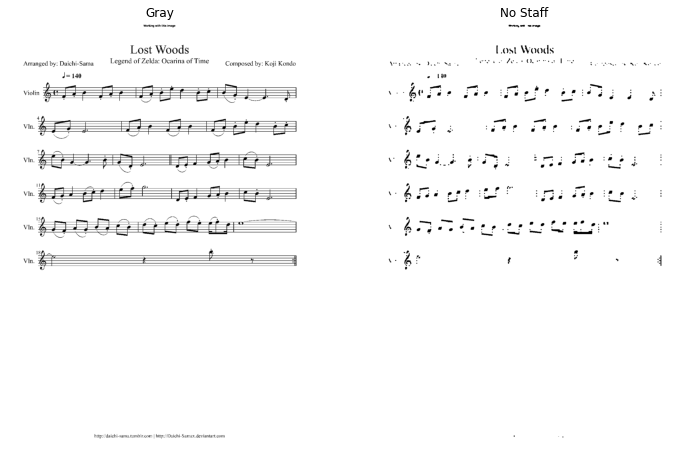

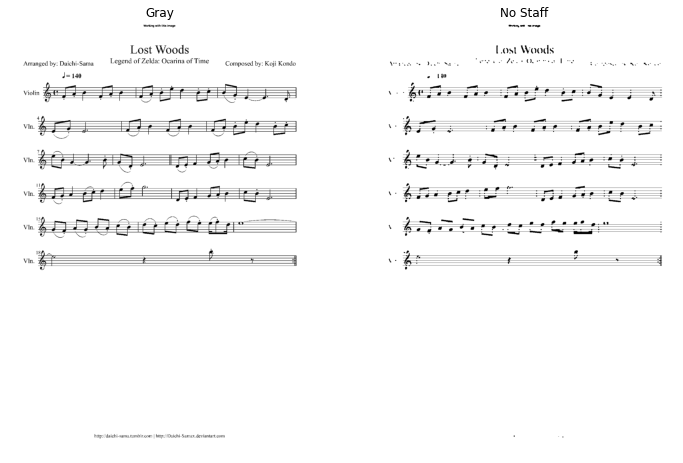

In [101]:
img = io.imread('dataset/lost.png')
original = img.copy()
gray = gray_img(img)
bin_img = otsu(gray)
# show_images([gray, bin_img], ['Gray', 'Binary'])

rle, vals = rle_img(bin_img)
most_common = get_most_common(rle)
thickness, spacing, _ = get_thickness_spacing(rle, most_common)
print(thickness, spacing)

no_h_staff = remove_h_lines(bin_img, thickness)
no_v_staff = remove_v_lines(no_h_staff, thickness)
img_without_staff = np.copy(no_v_staff)

canny_img = 255 - 255*(abs(gray-no_h_staff)).astype(np.uint8)
edges = canny(canny_img, sigma=0.5, low_threshold=50, high_threshold=250)
# show_images([canny_img, edges], ['Canny Image', 'Edges'])
lines = probabilistic_hough_line(255-gray, threshold=edges.shape[1]//2)
# print(lines)
show_images([gray, no_v_staff], ['Gray', 'No Staff'])

filtered_lines = []
lines = sorted(lines, key=lambda l : l[0][1])
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - filtered_lines[-1][0][1] < 0.9*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        filtered_lines.append(line)
        rr, cc = draw.line(x0, y0, x1, y0)
        # print(rr, cc)
        no_v_staff[cc, rr] = 0
show_images([gray, no_v_staff], ['Gray', 'No Staff'])
# inv_bin = 255 - bin_img
# show_images([inv_bin], ['Inverted'])


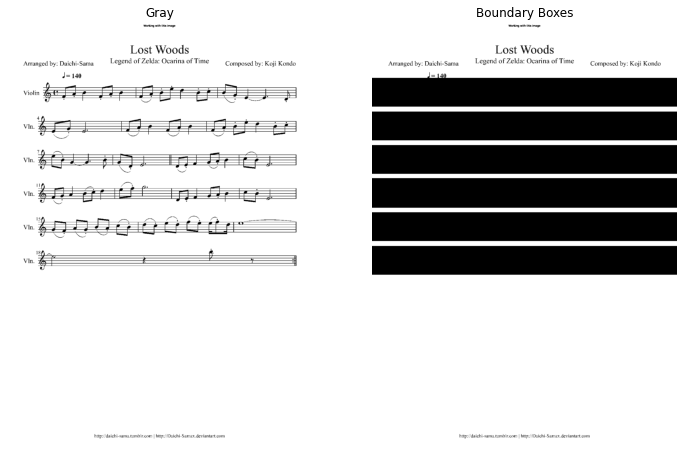

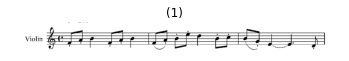

(132, 1409)


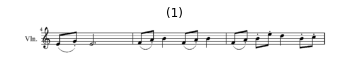

(132, 1409)


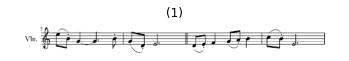

(132, 1409)


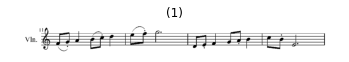

(136, 1409)


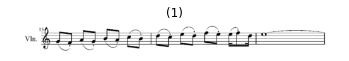

(132, 1409)


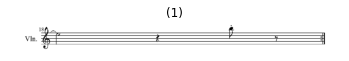

(132, 1409)


In [53]:
top_bottom_lines = []
for index, line in enumerate(filtered_lines):
    if index > 0 and (line[0][1] - top_bottom_lines[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        top_bottom_lines.append((x0, y0, x1, y1))

consec_dists = []
for i in range(len(top_bottom_lines)-1):
    consec_dists.append(top_bottom_lines[i+1][1] - top_bottom_lines[i][1])

max_spacing = max(consec_dists)
box_margin = max_spacing//2

centers = []
for i in range(0, len(top_bottom_lines)-1, 2):
    center = (top_bottom_lines[i+1][1] - top_bottom_lines[i][1])//2
    center_y = top_bottom_lines[i][1] + center
    centers.append((center_y, center))

display_margin = max_spacing // 10
roi = []
bboxes = np.copy(gray)
staff_imgs = []
original_staves = []
for index, (center, offset) in enumerate(centers):
    top = int(center) - box_margin - offset + display_margin
    bottom = int(center) + box_margin + offset - display_margin
    roi.append((top, bottom))
    rr, cc = draw.rectangle(start = (top, 0), end = (bottom, bboxes.shape[1]), shape=bboxes.shape)
    staff_img = gray[top:bottom, 0:bboxes.shape[1]]
    # print(staff_img)
    staff_imgs.append(staff_img)
    original_staves.append(original[top:bottom, 0:bboxes.shape[1]])
    bboxes[rr, cc] = 0
show_images([gray, bboxes], ['Gray', 'Boundary Boxes'])

for staff_img in staff_imgs:
    show_images([staff_img])
    print(staff_img.shape)

In [84]:
clef_lower, clef_upper, clef_thresh = 50, 70, 0.7

clef_imgs = {
    "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
    "bass": [io.imread('dataset/bass_1.jpg')]
}

In [16]:
def match(img, templates, start, stop, threshold):
    # height, width = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    x = []
    y = []
    for scale in [i/100.0 for i in range(start, stop+1, 3)]:
        locations = []
        location_count = 0
        for template in templates:
            if scale*template.shape[0] > img.shape[0] or scale*template.shape[1] > img.shape[1]:
                continue

            template = resize(template, (int(scale*template.shape[0]), int(scale*template.shape[1])))
            template = gray_img(template)
            result = match_template(img, template)
            result = np.where(result >= threshold)
            location_count += len(result[0])
            locations += [result]
        x.append(location_count)
        y.append(scale)

        if location_count > best_location_count:
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
        elif location_count < best_location_count:
            pass
    
    return best_locations, best_scale

In [17]:
def find_templates(img, templates, start, stop, threshold):
    locations, scale = match(img, templates, start, stop, threshold)
    img_locations = []
    for i in range(len(templates)):
        # h, w = templates[i].shape
        h = templates[i].shape[0]
        w = templates[i].shape[1]
        # print(templates[i].shape)
        w *= scale
        h *= scale
        img_locations.append([(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
    
    return img_locations

In [18]:
def calculate_overlap(a, b):
    overlap_x = max(0, min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0]))
    overlap_y = max(0, min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1]))
    overlap_area = overlap_x*overlap_y
    area = a[2]*a[3]
    return overlap_area/area

In [19]:
def merge2boxes(a, b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

In [20]:
def merge_boxes(boxes, threshold):
    filtered_boxes = []
    while len(boxes) > 0:
        r = boxes.pop(0)
        boxes.sort(key=lambda box: np.sqrt( ((box[0]+box[2]/2) - (r[0]+r[2]/2))**2 + ((box[1]+box[3]/2) - (r[1]+r[3]/2))**2))
        merged = True
        while merged:
            merged = False
            i = 0
            for _ in range(len(boxes)):
                if calculate_overlap(r, boxes[i]) > threshold or calculate_overlap(boxes[i], r) > threshold:
                    r = merge2boxes(r, boxes.pop(i))
                    merged = True
                elif np.sqrt(((boxes[i][0]+boxes[i][2]/2) - (r[0]+r[2]/2))**2+((boxes[i][1]+boxes[i][3]/2) - (r[1]+r[3]/2))**2) > r[2]/2 + boxes[i][2]/2:
                    break
                else:
                    i += 1
        filtered_boxes.append(r)
    return filtered_boxes

Matching clef images
Clef Found, الحمدلله treble


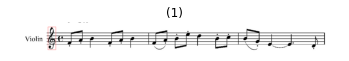

Matching clef images
Clef Found, الحمدلله treble


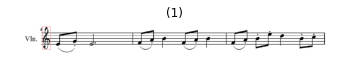

Matching clef images
Clef Found, الحمدلله treble


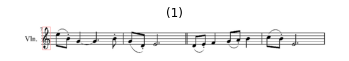

Matching clef images
Clef Found, الحمدلله treble


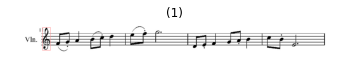

Matching clef images
Clef Found, الحمدلله treble


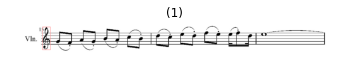

Matching clef images
Clef Found, الحمدلله treble


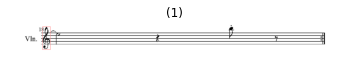

In [66]:
staff_clefs = [-1]*len(staff_imgs)
for i in range(len(staff_imgs)):
    for clef in clef_imgs:
        print("Matching clef images")
        clef_boxs = find_templates(staff_imgs[i], clef_imgs[clef], clef_lower, clef_upper, clef_thresh)
        clef_boxs = merge_boxes([j for i in clef_boxs for j in i], 0.5)

        if len(clef_boxs) == 1:
            print('Clef Found, الحمدلله', clef)
            staff_clefs[i] = clef

            clef_boxes_img = staff_imgs[i].copy()

            for boxes in clef_boxs:
                rr, cc = draw.rectangle_perimeter(start = (boxes[1], boxes[0]), end = (boxes[1]+boxes[3], boxes[0]+boxes[2]), shape=clef_boxes_img.shape)
                rr = np.array(rr,dtype='int')
                cc = np.array(cc,dtype='int')
                original_staves[i][rr, cc, 0] = 255
                original_staves[i][rr, cc, 1] = 0
                original_staves[i][rr, cc, 2] = 0
                io.imsave(f"clef{i+1}.png", original_staves[i])
                show_images([original_staves[i]])
            
            break
        else:
            print("No clef", i+1)

In [80]:
time_imgs = {
    "common": [io.imread(time) for time in ["dataset/common.jpg"]],
    "44": [io.imread(time) for time in ["dataset/44.png"]],
    "34": [io.imread(time) for time in ["dataset/34.jpg"]],
    "24": [io.imread(time) for time in ["dataset/24.jpg"]],
    "68": [io.imread(time) for time in ["dataset/68.jpg"]]
}
time_lower, time_upper, time_thresh = 50, 100, 0.7

Matching time images
Time Found, الحمدلله treble


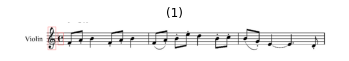

Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 3
Matching time images
Same as previous 3
Matching time images
Same as previous 3
Matching time images
Same as previous 3
Matching time images
Same as previous 3
Matching time images
Same as previous 4
Matching time images
Same as previous 4
Matching time images
Same as previous 4
Matching time images
Same as previous 4
Matching time images
Same as previous 4
Matching time images
Same as previous 5
Matching time images
Same as previous 5
Matching time images
Same as previous 5
Matching time images
Same as previous 5
Matching time images
Same as previous 5
Matching time images
Same as previous 6
Matching time images
Same as previous 6
Matching time images
Same as previous 6
Matching time images
Same as previous 6
Matching time images
Same as previous 6


In [83]:
staff_time = [-1]*len(staff_imgs)
for i in range(len(staff_imgs)):
    for time in time_imgs:
        print("Matching time images")
        time_boxes = find_templates(staff_imgs[i], time_imgs[time], time_lower, time_upper, time_thresh)
        time_boxes = merge_boxes([j for i in time_boxes for j in i], 0.5)

        if len(time_boxes) == 1:
            print('Time Found, الحمدلله', clef)
            staff_time[i] = time

            time_boxes_img = staff_imgs[i].copy()

            for boxes in time_boxes:
                rr, cc = draw.rectangle_perimeter(start = (boxes[1], boxes[0]), end = (boxes[1]+boxes[3], boxes[0]+boxes[2]), shape=time_boxes_img.shape)
                rr = np.array(rr,dtype='int')
                cc = np.array(cc,dtype='int')
                original_staves[i][rr, cc, 0] = 255
                original_staves[i][rr, cc, 1] = 0
                original_staves[i][rr, cc, 2] = 0
                io.imsave(f"time{i+1}.png", original_staves[i])
                show_images([original_staves[i]])
            
            break
        elif len(time_boxes) == 0 and i > 0:
            staff_time.append(staff_time[i-1])
            print("Same as previous", i+1)
        else:
            print("No time", i+1)